# Class-conditioned diffusion model with diffusers

- https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit1/01_introduction_to_diffusers.ipynb#scrollTo=cAFFaVJ6tFbk
- https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit1/02_diffusion_models_from_scratch.ipynb#scrollTo=uCwLPv1CinQr
- https://colab.research.google.com/github/huggingface/diffusion-models-class/blob/main/unit2/02_class_conditioned_diffusion_model_example.ipynb

In [ ]:
import torch
import torchvision
import torchvision.transforms as T
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm

from diffusers import DDPMScheduler, UNet2DModel

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

Using device: cuda


Number of samples: 60000
Number of batches: 7500
Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([8, 6, 2, 7, 3, 0, 0, 8])


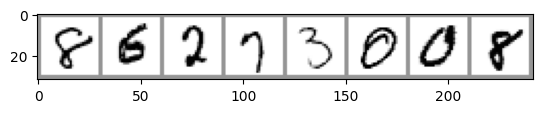

In [ ]:
# Load the dataset
dataset = torchvision.datasets.MNIST(
    root="data/",
    train=True, 
    download=True, 
    transform=T.Compose([
        T.ToTensor(),                 # [ 0, 1]
        T.Normalize((0.5,), (0.5,))   # [-1, 1]
    ])
)

print("Number of samples:", len(dataset))

# Feed it into a dataloader
train_dataloader = DataLoader(
    dataset, 
    batch_size=8, 
    shuffle=True
)

print("Number of batches:", len(train_dataloader))

# View some examples
x, y = next(iter(train_dataloader))
print('Input shape:', x.shape)
print('Labels:', y)
plt.imshow(torchvision.utils.make_grid(x)[0], cmap='Greys')
plt.show()

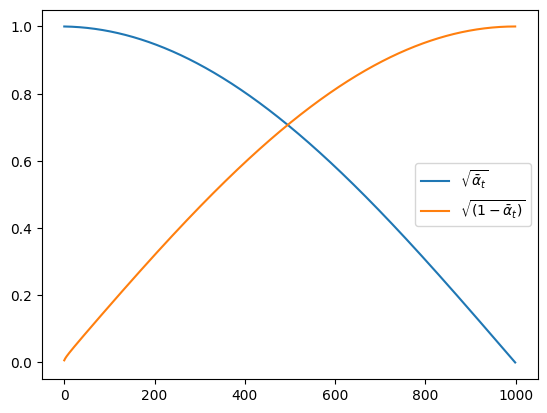

Timesteps: tensor([  0, 142, 285, 428, 570, 713, 856, 999], device='cuda:0')
X shape torch.Size([8, 1, 28, 28])
Noisy X shape torch.Size([8, 1, 28, 28])


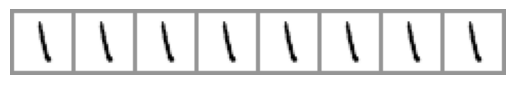

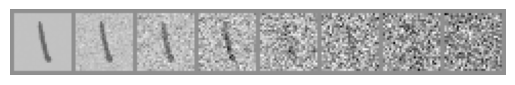

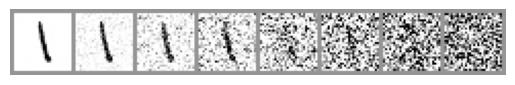

In [ ]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend()
plt.show()

N = 8
timesteps = torch.linspace(0, 999, N).long().to(device)
print("Timesteps:", timesteps)

idx = torch.randint(0, len(dataset), (1,)).item()
xb = torch.stack([dataset[idx][0]]*N)
print("X shape", xb.shape)

noise = torch.randn_like(xb)
noisy_xb = noise_scheduler.add_noise(xb, noise, timesteps)
print("Noisy X shape", noisy_xb.shape)

plt.figure()
plt.imshow(torchvision.utils.make_grid(xb)[0], cmap='Greys')
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(torchvision.utils.make_grid(noisy_xb)[0], cmap='Greys')
plt.axis('off')
plt.show()

plt.figure()
plt.imshow(torchvision.utils.make_grid(torch.clamp(noisy_xb, -1, 1))[0], cmap='Greys')
plt.axis('off')
plt.show()

The way we'll feed in the class conditioning is as follows:
- Create a standard `UNet2DModel` with some additional input channels  
- Map the class label to a learned vector of shape `(class_emb_size)` via an embedding layer
- Concatenate this information as extra channels for the internal UNet input with `net_input = torch.cat((x, class_cond), 1)`
- Feed this `net_input` (which has (`class_emb_size+1`) channels in total) into the UNet to get the final prediction

In this example I've set the class_emb_size to 4, but this is completely arbitrary and you could explore having it size 1 (to see if it still works), size 10 (to match the number of classes), or replacing the learned nn.Embedding with a simple one-hot encoding of the class label directly. 

In [ ]:
class ClassConditionedUNet(nn.Module):
    def __init__(self, num_classes=10, class_emb_size=4):
        super().__init__()

        # The embedding layer will map the class label to a vector of size `class_emb_size`
        self.class_emb = nn.Embedding(num_classes, class_emb_size)

        # self.model is an unconditional UNet with extra input channels to accept the conditioning information (the class embedding)
        self.model = UNet2DModel(
            sample_size = 28,                      # the target image resolution
            in_channels = 1 + class_emb_size,      # Additional input channels for class cond.
            out_channels = 1,                      # the number of output channels
            layers_per_block = 2,                  # how many ResNet layers to use per UNet block
            block_out_channels = (32, 64, 64),
            down_block_types=( 
                "DownBlock2D",                     # a regular ResNet downsampling block
                "AttnDownBlock2D",                 # a ResNet downsampling block with spatial self-attention
                "AttnDownBlock2D",
            ), 
            up_block_types=(
                "AttnUpBlock2D", 
                "AttnUpBlock2D",                   # a ResNet upsampling block with spatial self-attention
                "UpBlock2D",                       # a regular ResNet upsampling block
            ),
        )

    # Our forward method now takes the class labels as an additional argument
    def forward(self, x, t, class_labels):
        # Shape of x:
        bs, ch, w, h = x.shape

        # class conditioning in right shape to add as additional input channels
        class_cond = self.class_emb(class_labels) # Map to embedding dimension  (bs, class_emb_size)
        # Expand to the spatial dimensions of the input image (bs, class_emb_size, w, h)
        class_cond = class_cond.view(bs, class_cond.shape[1], 1, 1).expand(bs, class_cond.shape[1], w, h)
        # x is shape (bs, 1, 28, 28) and class_cond is now (bs, 4, 28, 28)

        # Net input is now x and class cond concatenated together along dimension 1
        net_input = torch.cat((x, class_cond), 1) # (bs, 5, 28, 28)

        # Feed this to the UNet alongside the timestep and return the prediction
        return self.model(net_input, t).sample # (bs, 1, 28, 28)

Where previously we'd do something like `prediction = unet(x, t)` we'll now add the correct labels as a third argument (`prediction = unet(x, t, y)`) during training, and at inference we can pass whatever labels we want and if all goes well the model should generate images that match. `y` in this case is the labels of the MNIST digits, with values from 0 to 9.

In [ ]:
net = ClassConditionedUNet()
x, y = next(iter(train_dataloader))
print("x.shape", x.shape)
print("y.shape", y.shape)
t = torch.randint(0, 1000, (8,)).long()
net(x, t, y).shape

x.shape torch.Size([8, 1, 28, 28])
y.shape torch.Size([8])


torch.Size([8, 1, 28, 28])

In [ ]:
sum([p.numel() for p in net.parameters()])

1708201

100%|██████████| 469/469 [01:35<00:00,  4.90it/s]


Finished epoch 0. Average loss for this epoch: 0.080227


100%|██████████| 469/469 [01:35<00:00,  4.90it/s]


Finished epoch 1. Average loss for this epoch: 0.048388


100%|██████████| 469/469 [01:36<00:00,  4.87it/s]


Finished epoch 2. Average loss for this epoch: 0.044611


100%|██████████| 469/469 [01:36<00:00,  4.87it/s]


Finished epoch 3. Average loss for this epoch: 0.043149


100%|██████████| 469/469 [01:35<00:00,  4.92it/s]


Finished epoch 4. Average loss for this epoch: 0.042066


100%|██████████| 469/469 [01:35<00:00,  4.91it/s]


Finished epoch 5. Average loss for this epoch: 0.040879


100%|██████████| 469/469 [01:36<00:00,  4.86it/s]


Finished epoch 6. Average loss for this epoch: 0.040151


100%|██████████| 469/469 [01:37<00:00,  4.83it/s]


Finished epoch 7. Average loss for this epoch: 0.039720


100%|██████████| 469/469 [01:35<00:00,  4.89it/s]


Finished epoch 8. Average loss for this epoch: 0.039132


100%|██████████| 469/469 [01:34<00:00,  4.96it/s]


Finished epoch 9. Average loss for this epoch: 0.038949


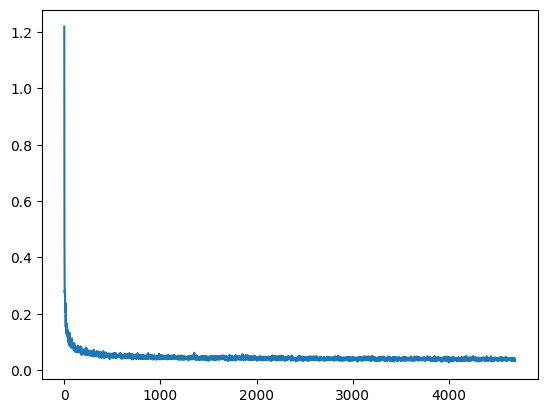

In [ ]:
# Create a scheduler
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 10

# Create the network
net = ClassConditionedUNet().to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3) 

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):
    for x, y in tqdm(train_dataloader):
        
        # Get some data and prepare the corrupted version
        x = x.to(device)
        y = y.to(device)
        noise = torch.randn_like(x)
        timesteps = torch.randint(0, 999, (x.shape[0],)).long().to(device)
        noisy_x = noise_scheduler.add_noise(x, noise, timesteps)

        # Get the model prediction
        pred = net(noisy_x, timesteps, y) # Note that we pass in the labels y

        # Calculate the loss
        loss = loss_fn(pred, noise) # How close is the output to the noise

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader):])/len(train_dataloader)
    print(f'Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}')

# View the loss curve
plt.plot(losses)
plt.show()

100%|██████████| 1000/1000 [00:35<00:00, 28.26it/s]


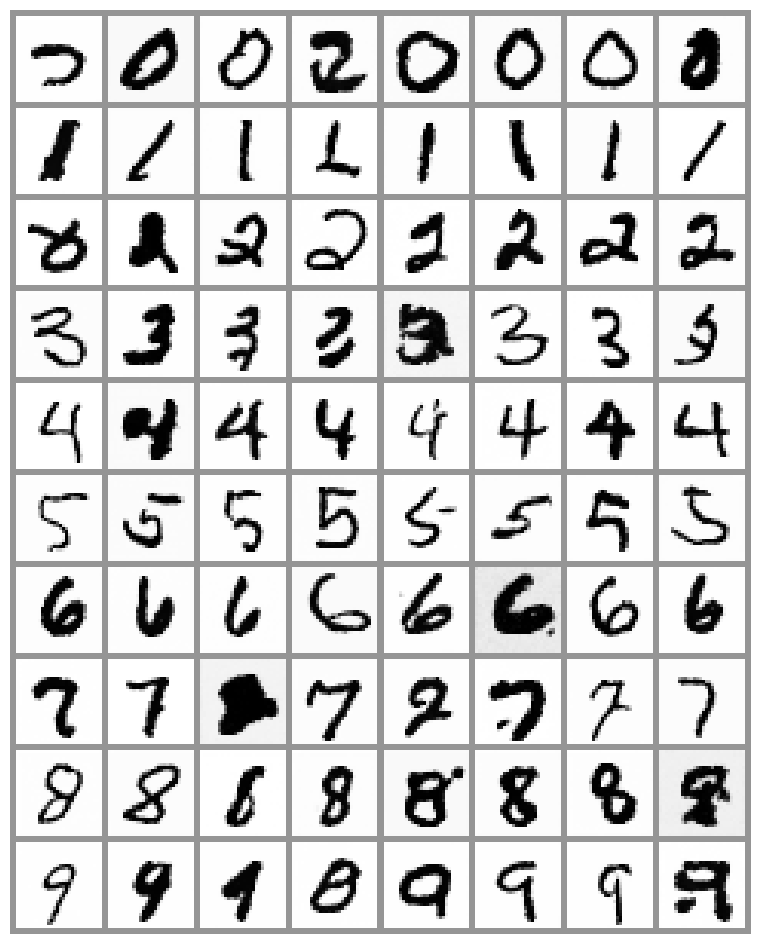

In [ ]:
# Noise scheduler for sampling
sample_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2')

# Prepare random x to start from, plus some desired labels y
x = torch.randn(80, 1, 28, 28).to(device)
y = torch.tensor([[i]*8 for i in range(10)]).flatten().to(device)

# Sampling loop
for t in tqdm(sample_scheduler.timesteps):

    # Get model pred
    with torch.no_grad():
        model_output = net(x, t, y)  # Again, note that we pass in our labels y

    # Update sample with step
    x = sample_scheduler.step(model_output, t, x).prev_sample

# Show the results
plt.figure(figsize=(12, 12))
plt.imshow(torchvision.utils.make_grid(x.detach().cpu().clip(-1, 1), nrow=8)[0], cmap='Greys')
plt.axis('off')
plt.show()